In this notebook we use raw text data and perfrom some normalization (case folding and punctuation removal) and use it to train models such as RNN, LSTM and GRU. The key difference from notebook 3 is that stop words will not be removed here which means the size of the vocabulary and length of the sequence wll be larger.

In [4]:
import numpy as np     
import pandas as pd    
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# load the dataset containing normalized text as well as the additional features obtained from notebook 1

df_train = pd.read_csv('Data\\disaster_tweets_kaggle\\train_clean_add_feat.csv', index_col = False)

df_train.head()

,text,target,text_norm,stemmed_keyword,disaster_asc_coeff,length_norm,neg,neu,pos
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us,earthquak,0.785714,41,0.000,1.000,0.0
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,fire,0.386364,36,0.286,0.714,0.0
2,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,evacu,0.767241,69,0.000,1.000,0.0
3,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california,evacu,0.767241,49,0.000,1.000,0.0
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,fire,0.386364,52,0.000,1.000,0.0


In [6]:
# In this part we will compare results using the original text with minimum processing vs the normalized text 
df_orig = df_train[['text', 'target']]

## Some Normalization
Minimum normalization will be applied to the text data in this case which is case folding and punctuation removal. Stop words will not be removed.

In [24]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import string

In [25]:
# we will fill null values for 'keyword' based on the list of present keywords that was just created
def normalize(raw_text):
    
    # remove hyperlink
    text_c1 = raw_text.split('http')[0].strip()
    
    # remove username
    text_c2 = ' '.join([word for word in text_c1.split() if '@' not in word])
    
    # remove all other punctuation
    text_c3 = ''.join([ch for ch in text_c2 if ch not in string.punctuation])
    
    # remove numbers
    text_c4 = ' '.join([word for word in text_c3.split() if not word.isnumeric()])
    
    
    # convert text to lowercase
    text_c5 = text_c4.lower()
    
    # stemming
    stemmer = PorterStemmer()
    text_c6 = ''.join([stemmer.stem(word) for word in text_c5])
    
    return text_c6

In [26]:
df_xnorm = df_orig['text'].apply(normalize)

In [27]:
df_xnorm.head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    people receive wildfires evacuation orders in ...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

#### Prepare text data for embedding

In [28]:
# use tokenizer and padding to prepare data for embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [29]:
tokenizer = Tokenizer()

In [30]:
# fit text to data
tokenizer.fit_on_texts(df_xnorm)

In [31]:
# tokenize text data
df_tokens = tokenizer.texts_to_sequences(df_xnorm)
df_tokens[0]

[104, 4160, 20, 1, 782, 5, 18, 298, 118, 1595, 4161, 67, 39]

In [32]:
# get max length to pad sequences and abd vocab size
VOCAB_SIZE = len(tokenizer.word_index) + 1
MAX_LENGTH = max([len(text.split()) for text in df_xnorm])
EMBEDDING_DIM = 200
print(f'Vocab size: {VOCAB_SIZE}')
print(f'Max sequence length: {MAX_LENGTH}')
print(f'Embedding dim: {EMBEDDING_DIM}')

Vocab size: 14864
Max sequence length: 31
Embedding dim: 200


In [33]:
# add padding
df_pad = pad_sequences(df_tokens, maxlen = MAX_LENGTH, padding = 'post')
df_pad[0]

array([ 104, 4160,   20,    1,  782,    5,   18,  298,  118, 1595, 4161,
         67,   39,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [34]:
print(type(df_pad))
print(df_pad.shape)

<class 'numpy.ndarray'>
(7593, 31)


### Train Test Split

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X = df_pad
y = df_orig['target']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [38]:
X_train[0]

array([ 893,   17, 1203, 5260,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

### Simple RNN model
Since the goal is to train a binary classification model, the RNN architecture will be many-to-one.

In [39]:
# basic architecture from tensorflow classiication with RNN documentation
import tensorflow as tf

In [40]:
model = tf.keras.Sequential()

The embedding layer converts the numeric representation of a word which would be a vector the length of the vocabularity if it were a dummy variable(with all entried 0's ecxept 1) and converts it to a vector of fixed length with all entries as floating point values. Therefore, instead of having a large sparse matrix for a sentence, we will have a smaller dense matrix as input. <br>
input_dim : Size of the vocabulary <br>
output_dim : Length of the embedded vector for each word <br>
input_length : Maximum length of a sequence

In [41]:
model.add(tf.keras.layers.Embedding(input_dim = VOCAB_SIZE,
        output_dim = EMBEDDING_DIM, input_length = MAX_LENGTH, mask_zero=True))
model.add(tf.keras.layers.SimpleRNN(EMBEDDING_DIM, dropout = 0.3))
model.add(tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.25))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.25))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 200)           2972800   
                                                                 
 simple_rnn (SimpleRNN)      (None, 200)               80200     
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                12864     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2

In [43]:
# compile model
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

### Train Model

In [44]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 7,
                    validation_split = 0.25)

Epoch 1/7
120/120 [==============================] - 8s 52ms/step - loss: 0.6878 - accuracy: 0.5552 - val_loss: 0.6756 - val_accuracy: 0.5888
Epoch 2/7
120/120 [==============================] - 6s 49ms/step - loss: 0.6500 - accuracy: 0.6312 - val_loss: 0.5995 - val_accuracy: 0.7288
Epoch 3/7
120/120 [==============================] - 6s 48ms/step - loss: 0.5290 - accuracy: 0.7722 - val_loss: 0.5275 - val_accuracy: 0.7524
Epoch 4/7
120/120 [==============================] - 6s 49ms/step - loss: 0.3910 - accuracy: 0.8511 - val_loss: 0.5209 - val_accuracy: 0.7508
Epoch 5/7
120/120 [==============================] - 7s 55ms/step - loss: 0.2646 - accuracy: 0.9025 - val_loss: 0.5622 - val_accuracy: 0.7673
Epoch 6/7
120/120 [==============================] - 7s 58ms/step - loss: 0.2025 - accuracy: 0.9245 - val_loss: 0.6453 - val_accuracy: 0.7563
Epoch 7/7
120/120 [==============================] - 7s 57ms/step - loss: 0.1502 - accuracy: 0.9450 - val_loss: 0.7414 - val_accuracy: 0.7421


In [45]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.7709736034274102)

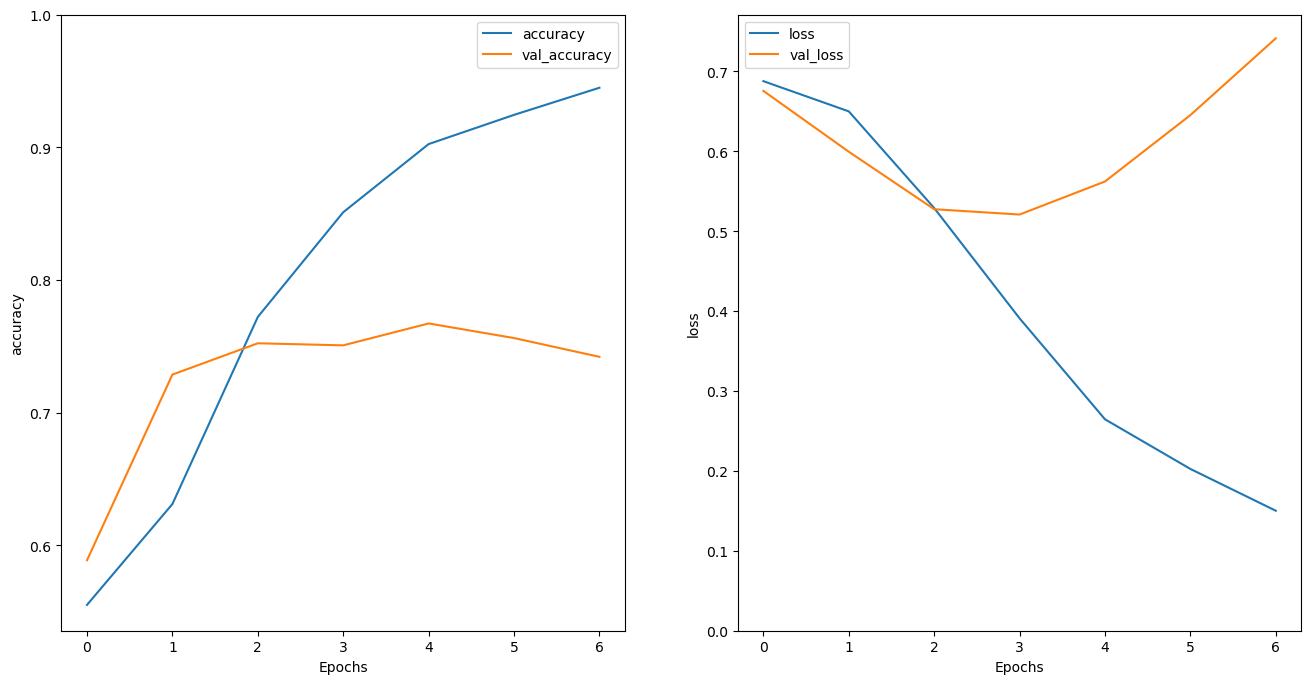

In [46]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [47]:
test_loss, test_acc = model.evaluate(X_test, y_test)

79/79 [==============================] - 1s 10ms/step - loss: 0.7811 - accuracy: 0.7374


In [48]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.7811208367347717
Test Accuracy: 0.7374301552772522


### LSTM

In [49]:
model_lstm = tf.keras.Sequential()

In [50]:
model_lstm.add(tf.keras.layers.Embedding(input_dim = VOCAB_SIZE,
        output_dim = EMBEDDING_DIM, input_length = MAX_LENGTH, mask_zero=True))
model_lstm.add(tf.keras.layers.LSTM(EMBEDDING_DIM, dropout = 0.3))
model_lstm.add(tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'))
model_lstm.add(tf.keras.layers.Dropout(rate = 0.25))
model_lstm.add(tf.keras.layers.Dense(64, activation='relu'))
model_lstm.add(tf.keras.layers.Dropout(rate = 0.25))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [51]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 31, 200)           2972800   
                                                                 
 lstm (LSTM)                 (None, 200)               320800    
                                                                 
 dense_4 (Dense)             (None, 200)               40200     
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                12864     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)               

In [52]:
# compile model
model_lstm.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

### Train Model

In [53]:
history = model_lstm.fit(X_train, y_train, batch_size = 32, epochs = 7,
                    validation_split = 0.25)

Epoch 1/7
120/120 [==============================] - 17s 104ms/step - loss: 0.6886 - accuracy: 0.5567 - val_loss: 0.6711 - val_accuracy: 0.5833
Epoch 2/7
120/120 [==============================] - 12s 104ms/step - loss: 0.6227 - accuracy: 0.6765 - val_loss: 0.5710 - val_accuracy: 0.7484
Epoch 3/7
120/120 [==============================] - 13s 108ms/step - loss: 0.4379 - accuracy: 0.8322 - val_loss: 0.5155 - val_accuracy: 0.7642
Epoch 4/7
120/120 [==============================] - 13s 113ms/step - loss: 0.3006 - accuracy: 0.8878 - val_loss: 0.5384 - val_accuracy: 0.7893
Epoch 5/7
120/120 [==============================] - 13s 106ms/step - loss: 0.2191 - accuracy: 0.9198 - val_loss: 0.6144 - val_accuracy: 0.7775
Epoch 6/7
120/120 [==============================] - 12s 99ms/step - loss: 0.1644 - accuracy: 0.9397 - val_loss: 0.6334 - val_accuracy: 0.7689
Epoch 7/7
120/120 [==============================] - 14s 119ms/step - loss: 0.1307 - accuracy: 0.9552 - val_loss: 0.7473 - val_accuracy: 

In [54]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.778113565593958)

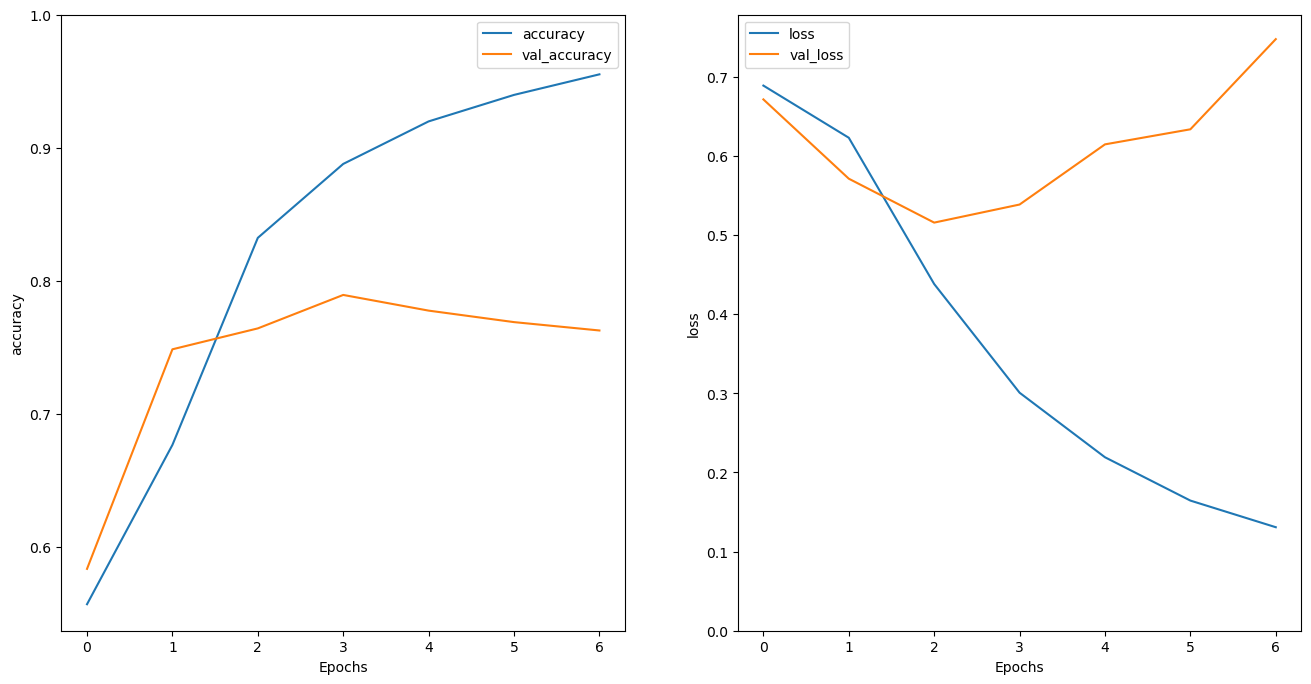

In [55]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [56]:
test_loss, test_acc = model_lstm.evaluate(X_test, y_test)

79/79 [==============================] - 3s 32ms/step - loss: 0.7699 - accuracy: 0.7622


In [57]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.7699159979820251
Test Accuracy: 0.7621707916259766


### Bidirectional LSTM

In [58]:
model_blstm = tf.keras.Sequential()

In [59]:
model_blstm.add(tf.keras.layers.Embedding(input_dim = VOCAB_SIZE,
        output_dim = EMBEDDING_DIM, input_length = MAX_LENGTH, mask_zero=True))
model_blstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIM, dropout = 0.3)))
model_blstm.add(tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'))
model_blstm.add(tf.keras.layers.Dropout(rate = 0.25))
model_blstm.add(tf.keras.layers.Dense(64, activation='relu'))
model_blstm.add(tf.keras.layers.Dropout(rate = 0.25))
model_blstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_blstm.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [60]:
model_blstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 31, 200)           2972800   
                                                                 
 bidirectional (Bidirectiona  (None, 400)              641600    
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 200)               80200     
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                12864     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                      

In [61]:
# compile model
model_blstm.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

### Train Model

In [62]:
history = model_blstm.fit(X_train, y_train, batch_size = 32, epochs = 7,
                    validation_split = 0.25)

Epoch 1/7
120/120 [==============================] - 39s 236ms/step - loss: 0.6841 - accuracy: 0.5685 - val_loss: 0.6606 - val_accuracy: 0.5833
Epoch 2/7
120/120 [==============================] - 24s 197ms/step - loss: 0.6015 - accuracy: 0.6813 - val_loss: 0.5729 - val_accuracy: 0.7642
Epoch 3/7
120/120 [==============================] - 24s 202ms/step - loss: 0.4122 - accuracy: 0.8506 - val_loss: 0.5119 - val_accuracy: 0.7594
Epoch 4/7
120/120 [==============================] - 24s 202ms/step - loss: 0.2556 - accuracy: 0.9085 - val_loss: 0.5627 - val_accuracy: 0.7531
Epoch 5/7
120/120 [==============================] - 24s 200ms/step - loss: 0.1704 - accuracy: 0.9442 - val_loss: 0.6323 - val_accuracy: 0.7673
Epoch 6/7
120/120 [==============================] - 24s 198ms/step - loss: 0.1279 - accuracy: 0.9573 - val_loss: 0.7760 - val_accuracy: 0.7453
Epoch 7/7
120/120 [==============================] - 23s 193ms/step - loss: 0.1137 - accuracy: 0.9596 - val_loss: 0.8126 - val_accuracy:

In [63]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.8475736729800701)

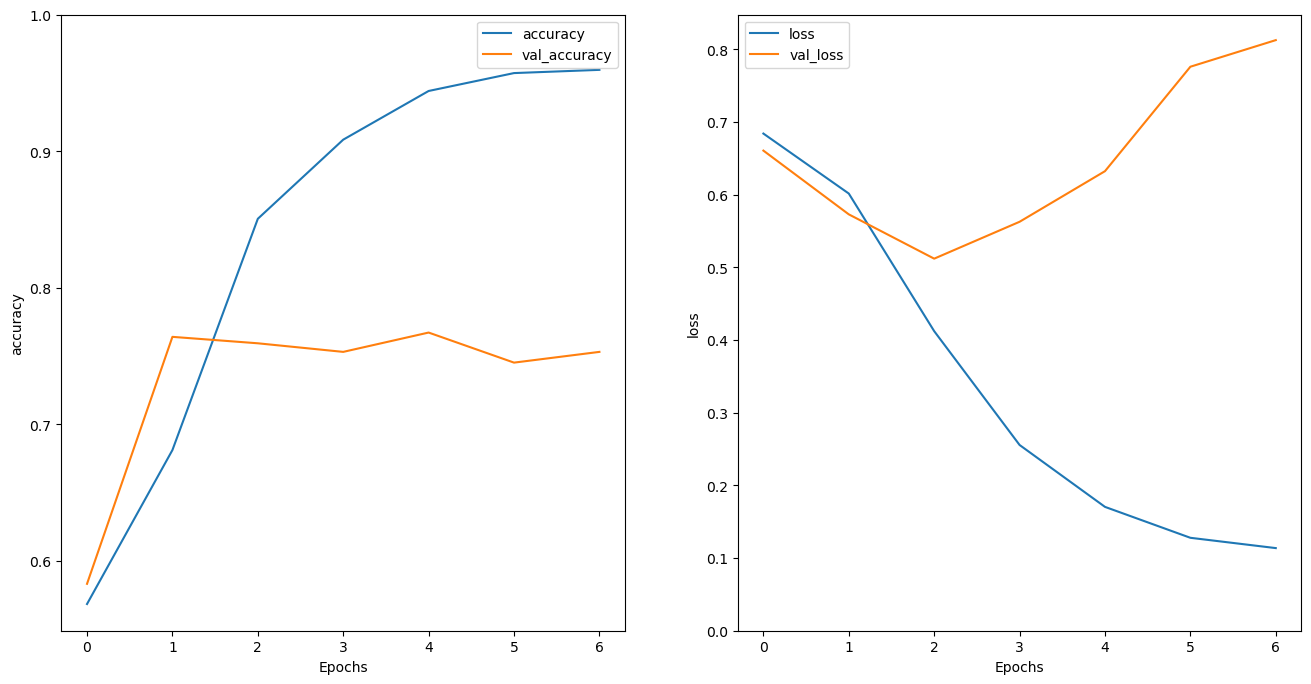

In [64]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [65]:
test_loss, test_acc = model_blstm.evaluate(X_test, y_test)

79/79 [==============================] - 4s 47ms/step - loss: 0.8802 - accuracy: 0.7478


In [66]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.8801842331886292
Test Accuracy: 0.7478052377700806


### GRU

In [67]:
model_gru = tf.keras.Sequential()

In [68]:
model_gru.add(tf.keras.layers.Embedding(input_dim = VOCAB_SIZE,
        output_dim = EMBEDDING_DIM, input_length = MAX_LENGTH, mask_zero=True))
model_gru.add(tf.keras.layers.GRU(EMBEDDING_DIM, dropout = 0.3))
model_gru.add(tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'))
model_gru.add(tf.keras.layers.Dropout(rate = 0.25))
model_gru.add(tf.keras.layers.Dense(64, activation='relu'))
model_gru.add(tf.keras.layers.Dropout(rate = 0.25))
model_gru.add(tf.keras.layers.Dense(32, activation='relu'))
model_gru.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [69]:
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 31, 200)           2972800   
                                                                 
 gru (GRU)                   (None, 200)               241200    
                                                                 
 dense_12 (Dense)            (None, 200)               40200     
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                12864     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)               

In [70]:
# compile model
model_gru.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

### Train Model

In [71]:
history = model_gru.fit(X_train, y_train, batch_size = 32, epochs = 7,
                    validation_split = 0.25)

Epoch 1/7
120/120 [==============================] - 22s 122ms/step - loss: 0.6883 - accuracy: 0.5675 - val_loss: 0.6805 - val_accuracy: 0.5833
Epoch 2/7
120/120 [==============================] - 16s 132ms/step - loss: 0.6645 - accuracy: 0.5746 - val_loss: 0.6049 - val_accuracy: 0.7186
Epoch 3/7
120/120 [==============================] - 14s 119ms/step - loss: 0.4933 - accuracy: 0.8089 - val_loss: 0.4890 - val_accuracy: 0.7759
Epoch 4/7
120/120 [==============================] - 14s 115ms/step - loss: 0.3185 - accuracy: 0.8750 - val_loss: 0.5047 - val_accuracy: 0.7728
Epoch 5/7
120/120 [==============================] - 10s 86ms/step - loss: 0.2166 - accuracy: 0.9172 - val_loss: 0.5423 - val_accuracy: 0.7783
Epoch 6/7
120/120 [==============================] - 11s 93ms/step - loss: 0.1544 - accuracy: 0.9436 - val_loss: 0.6432 - val_accuracy: 0.7862
Epoch 7/7
120/120 [==============================] - 13s 107ms/step - loss: 0.1210 - accuracy: 0.9581 - val_loss: 0.6603 - val_accuracy: 0

In [72]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.7166301429271698)

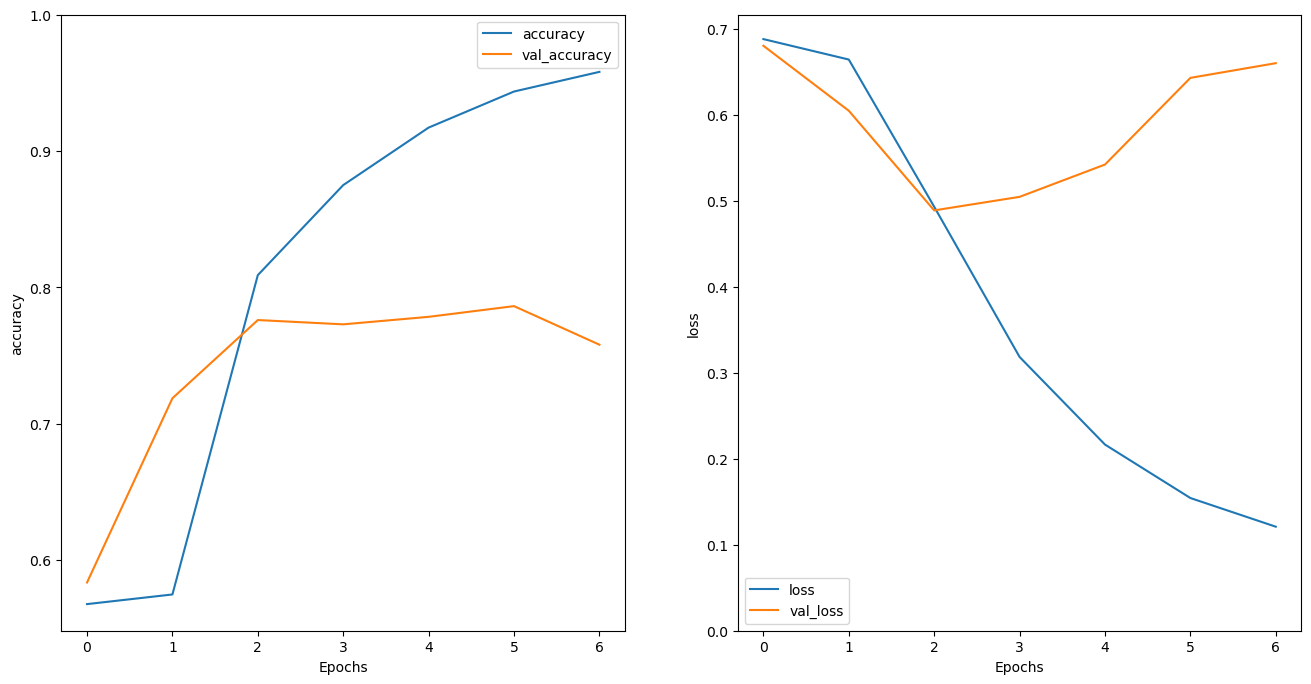

In [73]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [74]:
test_loss, test_acc = model_gru.evaluate(X_test, y_test)

79/79 [==============================] - 3s 31ms/step - loss: 0.7255 - accuracy: 0.7538


In [75]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.72547447681427
Test Accuracy: 0.7537909150123596


### Conclusion for Test Accuracy
SimpleRNN: 0.7374<br>
LSTM:  0.7621<br>
Bidirectional LSTM: 0.7478<br>
GRU: 0.7537